# [第8章: 機械学習](http://www.cl.ecei.tohoku.ac.jp/nlp100/#ch8)
本章では，Bo Pang氏とLillian Lee氏が公開している[Movie Review Data](http://www.cs.cornell.edu/people/pabo/movie-review-data/)の[sentence polarity dataset v1.0](http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.README.1.0.txt)を用い，文を肯定的（ポジティブ）もしくは否定的（ネガティブ）に分類するタスク（極性分析）に取り組む．

## 70. データの入手・整形
[文に関する極性分析の正解データ](http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz)を用い，以下の要領で正解データ（sentiment.txt）を作成せよ．
1. rt-polarity.posの各行の先頭に"+1 "という文字列を追加する（極性ラベル"+1"とスペースに続けて肯定的な文の内容が続く）
2. rt-polarity.negの各行の先頭に"-1 "という文字列を追加する（極性ラベル"-1"とスペースに続けて否定的な文の内容が続く）
3. 上述1と2の内容を結合（concatenate）し，行をランダムに並び替える

sentiment.txtを作成したら，正例（肯定的な文）の数と負例（否定的な文）の数を確認せよ．

In [1]:
!ls ../Corpus/rt-polarity.*

../Corpus/rt-polarity.neg  ../Corpus/rt-polarity.pos


In [2]:
import random

In [3]:
random.seed(70)

In [4]:
with open("../Corpus/rt-polarity.pos", "rb") as pos, open("../Corpus/rt-polarity.neg", "rb") as neg:
    sentiment_lines = []
    sentiment_lines.extend([b"+1 " + pos_line for pos_line in pos])
    sentiment_lines.extend([b"-1 " + neg_line for neg_line in neg])
    random.shuffle(sentiment_lines)
    with open("rt-polarity.sentiment", "wb") as sentiment:
        for sentiment_line in sentiment_lines:
            sentiment.write(sentiment_line)

In [5]:
!head -10 rt-polarity.sentiment

+1 passions , obsessions , and loneliest dark spots are pushed to their most virtuous limits , lending the narrative an unusually surreal tone . 
+1 it is a kickass , dense sci-fi action thriller hybrid that delivers and then some . i haven't seen one in so long , no wonder i didn't recognize it at first . 
-1 the film takes too long getting to the good stuff , then takes too long figuring out what to do next . 
+1 leguizamo and jones are both excellent and the rest of the cast is uniformly superb . 
+1 if s&m seems like a strange route to true love , maybe it is , but it's to this film's ( and its makers' ) credit that we believe that that's exactly what these two people need to find each other -- and themselves . 
-1 a mediocre exercise in target demographics , unaware that it's the butt of its own joke . 
+1 if you thought tom hanks was just an ordinary big-screen star , wait until you've seen him eight stories tall . 
-1 the overall feel is not unlike watching a glorified episode o

## 71. ストップワード
英語のストップワードのリスト（ストップリスト）を適当に作成せよ．さらに，引数に与えられた単語（文字列）がストップリストに含まれている場合は真，それ以外は偽を返す関数を実装せよ．さらに，その関数に対するテストを記述せよ．

In [6]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [7]:
stop_words = list(ENGLISH_STOP_WORDS)

In [8]:
#stop_words
stop_words[:10]

['further',
 'never',
 'fifteen',
 'else',
 'two',
 'such',
 'would',
 'less',
 'ever',
 'un']

In [9]:
def check_stop_words(word: str):
    return word in stop_words

In [10]:
print("we : %s" % check_stop_words("we"))
print("nlp : %s" % check_stop_words("nlp"))

we : True
nlp : False


## 72. 素性抽出
極性分析に有用そうな素性を各自で設計し，学習データから素性を抽出せよ．素性としては，レビューからストップワードを除去し，各単語をステミング処理したものが最低限のベースラインとなるであろう．

In [11]:
from nltk.stem.porter import PorterStemmer

In [12]:
labels = []
lines = []
features = []
porter = PorterStemmer()

# 文字化けによるエンコーディングエラー時は、その文字を無視
with open("rt-polarity.sentiment", errors="ignore") as sentiment:
    for sentiment_line in sentiment:
        label, line, stem_words = int(sentiment_line[0:2]), sentiment_line[3:], []

        for word in line.split():
            if not check_stop_words(word):
                stem_words.append(porter.stem(word))
        if len(stem_words) == 0:
            continue

        labels.append(label)
        lines.append(line)
        features.append(" ".join(stem_words))

In [13]:
#features
features[:10]

['passion , obsess , loneliest dark spot push virtuou limit , lend narr unusu surreal tone .',
 "kickass , dens sci-fi action thriller hybrid deliv . haven't seen long , wonder didn't recogn .",
 'film take long get good stuff , take long figur .',
 'leguizamo jone excel rest cast uniformli superb .',
 "s&m like strang rout true love , mayb , it' film' ( makers' ) credit believ that' exactli peopl need -- .",
 "mediocr exercis target demograph , unawar it' butt joke .",
 "thought tom hank just ordinari big-screen star , wait you'v seen stori tall .",
 'overal feel unlik watch glorifi episod " 7th heaven . "',
 "it' cram scene vista pretti moment it' left crucial thing , like charact develop coher .",
 "remark excel storytel , econom , compress characteris profound human , it' adventur stori histori lesson ."]

In [14]:
#labels
labels[:10]

[1, 1, -1, 1, 1, -1, 1, -1, -1, 1]

## 73. 学習
72で抽出した素性を用いて，ロジスティック回帰モデルを学習せよ．

In [15]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [16]:
# ここでは、tf-idfによるベクトル化により、コーパスから学習データを作成
tf_idf = TfidfVectorizer().fit(features)
X = tf_idf.transform(features)
X

<10662x13296 sparse matrix of type '<class 'numpy.float64'>'
	with 106372 stored elements in Compressed Sparse Row format>

In [17]:
y = np.array(labels)
y.size

10662

In [18]:
model_73 = LogisticRegression(random_state=73)
model_73.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=73, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
model_73.score(X, y)

0.881541924592009

## 74. 予測
73で学習したロジスティック回帰モデルを用い，与えられた文の極性ラベル（正例なら"+1"，負例なら"-1"）と，その予測確率を計算するプログラムを実装せよ．

In [20]:
#for i in range(len(lines)):
for i in range(10):
    line = lines[i]
    label = "-1" if labels[i] == -1 else "+1"
    pred = "-1" if model_73.predict(X[i]) == -1 else "+1"
    probs = model_73.predict_proba(X[i])[0]
    prob = probs[0] if pred == "-1" else probs[1]

    args = (line, label, pred, prob)
    print("%s-> Label:%s, Predict:%s, Probability:%f" % args)
    print()

passions , obsessions , and loneliest dark spots are pushed to their most virtuous limits , lending the narrative an unusually surreal tone . 
-> Label:+1, Predict:+1, Probability:0.687160

it is a kickass , dense sci-fi action thriller hybrid that delivers and then some . i haven't seen one in so long , no wonder i didn't recognize it at first . 
-> Label:+1, Predict:-1, Probability:0.526148

the film takes too long getting to the good stuff , then takes too long figuring out what to do next . 
-> Label:-1, Predict:-1, Probability:0.561616

leguizamo and jones are both excellent and the rest of the cast is uniformly superb . 
-> Label:+1, Predict:+1, Probability:0.618260

if s&m seems like a strange route to true love , maybe it is , but it's to this film's ( and its makers' ) credit that we believe that that's exactly what these two people need to find each other -- and themselves . 
-> Label:+1, Predict:+1, Probability:0.688766

a mediocre exercise in target demographics , unaware t

## 75. 素性の重み
73で学習したロジスティック回帰モデルの中で，重みの高い素性トップ10と，重みの低い素性トップ10を確認せよ．

In [21]:
indices = np.argsort(model_73.coef_[0])
indices.shape

(13296,)

In [22]:
print("[Best 10 Features]")
for i in range(-1, -11, -1):
    best_idx = indices[i]
    best_feature = [k for k, v in tf_idf.vocabulary_.items() if v == best_idx]

    args = (-i, best_feature[0], model_73.coef_[0][best_idx])
    print("No.%s\t: %s\t(coef=%f)" % args)

[Best 10 Features]
No.1	: beauti	(coef=3.088591)
No.2	: perform	(coef=2.529640)
No.3	: enjoy	(coef=2.452630)
No.4	: solid	(coef=2.319076)
No.5	: entertain	(coef=2.318588)
No.6	: heart	(coef=2.315182)
No.7	: fun	(coef=2.315047)
No.8	: best	(coef=2.280014)
No.9	: cinema	(coef=2.245044)
No.10	: engross	(coef=2.237097)


In [23]:
print("[Worst 10 Features]")
for i in range(10):
    worst_idx = indices[i]
    worst_feature = [k for k, v in tf_idf.vocabulary_.items() if v == worst_idx]

    args = (i+1, worst_feature[0], model_73.coef_[0][worst_idx])
    print("No.%s\t: %s\t(coef=%f)" % args)

[Worst 10 Features]
No.1	: bore	(coef=-3.396291)
No.2	: bad	(coef=-3.219395)
No.3	: dull	(coef=-3.081518)
No.4	: lack	(coef=-2.600852)
No.5	: worst	(coef=-2.562439)
No.6	: fail	(coef=-2.535151)
No.7	: joke	(coef=-2.249139)
No.8	: thing	(coef=-2.115947)
No.9	: mediocr	(coef=-2.111887)
No.10	: wast	(coef=-2.092020)


## 76. ラベル付け
学習データに対してロジスティック回帰モデルを適用し，正解のラベル，予測されたラベル，予測確率をタブ区切り形式で出力せよ．

In [24]:
with open("LogisticRegression_76.log", "w") as f:
    for i in range(len(lines)):
        pred = model_73.predict(X[i])
        probs = model_73.predict_proba(X[i])[0]
        prob = probs[0] if pred == -1 else probs[1]

        args = (labels[i], pred, prob)
        f.write("%d\t%d\t%f\n" % args)

In [25]:
!head -10 LogisticRegression_76.log

1	1	0.687160
1	-1	0.526148
-1	-1	0.561616
1	1	0.618260
1	1	0.688766
-1	-1	0.935489
1	1	0.589269
-1	-1	0.761696
-1	-1	0.778911
1	1	0.890254


## 77. 正解率の計測
76の出力を受け取り，予測の正解率，正例に関する適合率，再現率，F1スコアを求めるプログラムを作成せよ．

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [27]:
with open("LogisticRegression_76.log") as f:
    y_true, y_pred = [], []
    for line in f:
        label, pred = line.split("\t")[0:2]
        y_true.append(int(label))
        y_pred.append(int(pred))

    print("Accuracy Score : %f" % accuracy_score(y_true, y_pred))
    print("Precision Score : %f" % precision_score(y_true, y_pred))
    print("Recall Score : %f" % recall_score(y_true, y_pred))
    print("F1 Score : %f" % f1_score(y_true, y_pred))

Accuracy Score : 0.881542
Precision Score : 0.885081
Recall Score : 0.876946
F1 Score : 0.880995


## 78. 5分割交差検定
76-77の実験では，学習に用いた事例を評価にも用いたため，正当な評価とは言えない．すなわち，分類器が訓練事例を丸暗記する際の性能を評価しており，モデルの汎化性能を測定していない．そこで，5分割交差検定により，極性分類の正解率，適合率，再現率，F1スコアを求めよ．

In [28]:
from sklearn.model_selection import KFold

In [29]:
threshold = 0.5
kf = KFold(n_splits=5, shuffle=True, random_state=78)

for i, (train_indices, valid_indices) in enumerate(kf.split(X)):
    X_train, X_valid, y_train, y_valid = X[train_indices], X[valid_indices], y[train_indices], y[valid_indices]

    model_78 = LogisticRegression(random_state=78)
    model_78.fit(X_train, y_train)

    y_pred = []
    for X_valid_inner in X_valid:
        prob_neg = model_78.predict_proba(X_valid_inner)[0][0]
        pred = -1 if prob_neg > threshold else 1
        y_pred.append(pred)

    print("[%d/5]" % (i+1))
    print("Accuracy Score : %f" % accuracy_score(y_valid, y_pred))
    print("Precision Score : %f" % precision_score(y_valid, y_pred))
    print("Recall Score : %f" % recall_score(y_valid, y_pred))
    print("F1 Score : %f" % f1_score(y_valid, y_pred))
    print()

[1/5]
Accuracy Score : 0.753399
Precision Score : 0.757986
Recall Score : 0.739377
F1 Score : 0.748566

[2/5]
Accuracy Score : 0.755274
Precision Score : 0.751156
Recall Score : 0.762441
F1 Score : 0.756757

[3/5]
Accuracy Score : 0.750469
Precision Score : 0.745042
Recall Score : 0.750714
F1 Score : 0.747867

[4/5]
Accuracy Score : 0.761726
Precision Score : 0.774879
Recall Score : 0.744661
F1 Score : 0.759470

[5/5]
Accuracy Score : 0.763133
Precision Score : 0.769231
Recall Score : 0.759963
F1 Score : 0.764569



## 79. 適合率-再現率グラフの描画
ロジスティック回帰モデルの分類の閾値を変化させることで，適合率-再現率グラフを描画せよ．

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [31]:
%matplotlib inline

In [32]:
sns.set(style="darkgrid", context="notebook", palette="muted")

In [33]:
thresholds = np.linspace(0.1, 0.9, 20)
recall_means = []
precision_means = []

for i, threshold in enumerate(thresholds):
    kf = KFold(n_splits=5, shuffle=True, random_state=79+i)
    precisions = []
    recalls = []

    for j, (train_indices, valid_indices) in enumerate(kf.split(X)):
        X_train, X_valid, y_train, y_valid = X[train_indices], X[valid_indices], y[train_indices], y[valid_indices]

        model_79 = LogisticRegression(random_state=79+5*i+j)
        model_79.fit(X_train, y_train)

        y_pred = []
        for X_valid_inner in X_valid:
            prob_neg = model_79.predict_proba(X_valid_inner)[0][0]
            pred = -1 if prob_neg > threshold else 1
            y_pred.append(pred)

        recalls.append(recall_score(y_valid, y_pred))
        precisions.append(precision_score(y_valid, y_pred))

    recall_mean = sum(recalls) / 5.0
    recall_means.append(recall_mean)
    precision_mean = sum(precisions) / 5.0
    precision_means.append(precision_mean)

    print("[%d/%d]\tthreshold=%f" % (i+1, 20, threshold))
    print("Recall Scores\t: %s\t(Mean=%f)" % (recalls, recall_mean))
    print("Precision Scores\t: %s\t(Mean=%f)" % (precisions, precision_mean))

[1/20]	threshold=0.100000
Recall Scores	: [0.013605442176870748, 0.01403180542563143, 0.014598540145985401, 0.02022058823529412, 0.015252621544327931]	(Mean=0.015542)
Precision Scores	: [1.0, 1.0, 1.0, 1.0, 1.0]	(Mean=1.000000)
[2/20]	threshold=0.142105
Recall Scores	: [0.05157593123209169, 0.044444444444444446, 0.04657794676806084, 0.0457516339869281, 0.04625346901017576]	(Mean=0.046921)
Precision Scores	: [0.9818181818181818, 0.9795918367346939, 1.0, 0.9607843137254902, 0.9803921568627451]	(Mean=0.980517)
[3/20]	threshold=0.184211
Recall Scores	: [0.09951690821256039, 0.10546139359698682, 0.07699194270367055, 0.1016949152542373, 0.07867298578199051]	(Mean=0.092468)
Precision Scores	: [0.9809523809523809, 0.9911504424778761, 0.9662921348314607, 0.9642857142857143, 0.9880952380952381]	(Mean=0.978155)
[4/20]	threshold=0.226316
Recall Scores	: [0.1537053979871912, 0.1577490774907749, 0.17238095238095238, 0.1665089877010407, 0.15759312320916904]	(Mean=0.161588)
Precision Scores	: [0.96551

In [34]:
data_79 = pd.DataFrame({
    "平均再現率": recall_means,
    "平均適合率": precision_means,
})

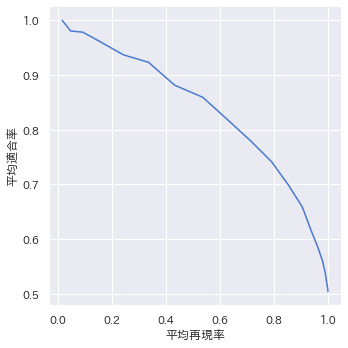

In [35]:
sns.relplot(x="平均再現率", y="平均適合率", data=data_79, kind="line")